
REWARD DISTRIBUTION ANALYSIS - Epoch 1000

1. BASIC STATISTICS:
   Mean: -8.2790
   Std:  87.9423
   Min:  -999.6500
   Max:  0.0000

2. VALUE CLUSTERING:
   Perfect (0.0):          25 (  9.8%)
   Small (0 to -0.5):     120 ( 46.9%)
   Medium (-0.5 to -2):   109 ( 42.6%)
   Large (< -2.0):          2 (  0.8%)

3. DISCRIMINATION POWER:
   Unique reward values: 231
   Rewards per scene:    256
   Discrimination ratio: 0.902

4. ADJACENT SCENE DIFFERENCES:
   Mean difference between consecutive rewards: 4.3463
   Std of rewards: 87.9423
   Ratio: 0.0494
   ⚠️  WEAK GRADIENT! Adjacent scenes are too similar!

5. AFTER Z-SCORE NORMALIZATION:
   Mean difference between consecutive normalized rewards: 0.0494
   🔴 CRITICAL: Normalized differences < 0.05 → Too weak for learning!


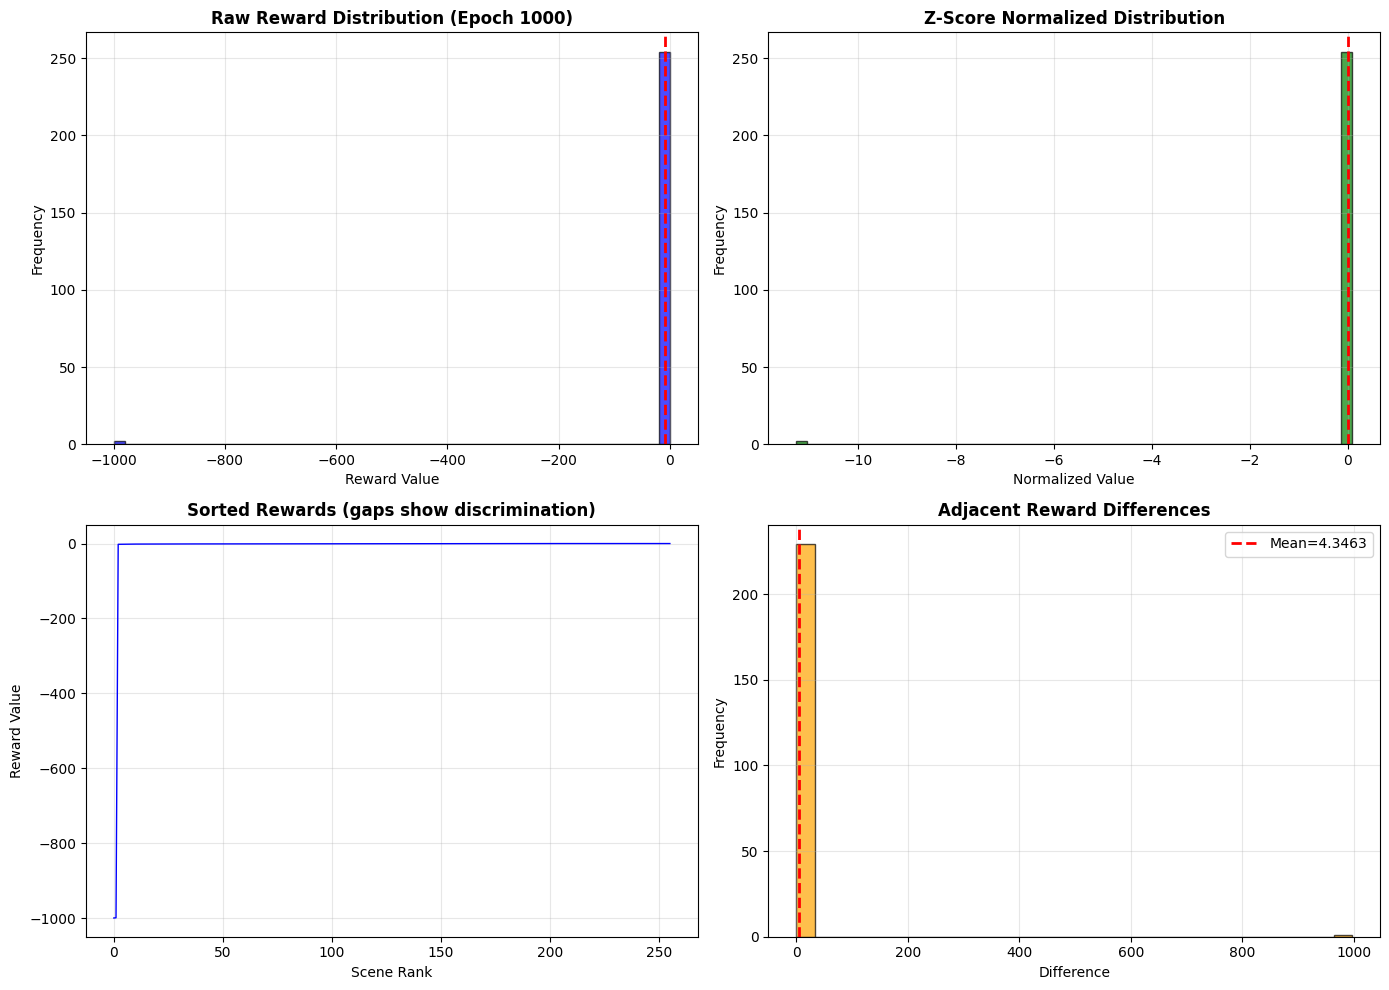

Found 2 outliers at indices: [146 147]
Outlier values: [-999.65 -999.  ]

DATASET COMPARISON
WITH outliers:    256 scenes
WITHOUT outliers: 254 scenes

STATISTICS COMPARISON

RAW REWARDS:
  WITH outliers:    mean=  -8.279, std=  87.942
  WITHOUT outliers: mean=  -0.475, std=   0.465
  → Std inflation: 18792.6%

SIGNAL STRENGTH COMPARISON (Z-SCORE NORMALIZED)

WITHOUT OUTLIERS (clean signal):
  Perfect (0.0) → Good (-0.2):  difference = 0.1164
  Good (-0.2)   → OK (-0.7):    difference = 1.5374
  OK (-0.7)     → Bad (-1.6):   difference = 1.8415
  ✅ All differences > 0.1 → Model can learn!

WITH OUTLIERS (contaminated signal):
  Perfect (0.0) → Good (-0.2):  difference = 0.0006
  Good (-0.2)   → OK (-0.7):    difference = 0.0081
  OK (-0.7)     → Bad (-1.6):   difference = 0.0097
  🔴 All differences < 0.05 → Model CANNOT learn!

SIGNAL COMPRESSION BY OUTLIERS
  Perfect→Good: 99.5% weaker signal
  Good→OK:      99.5% weaker signal
  OK→Bad:       99.5% weaker signal


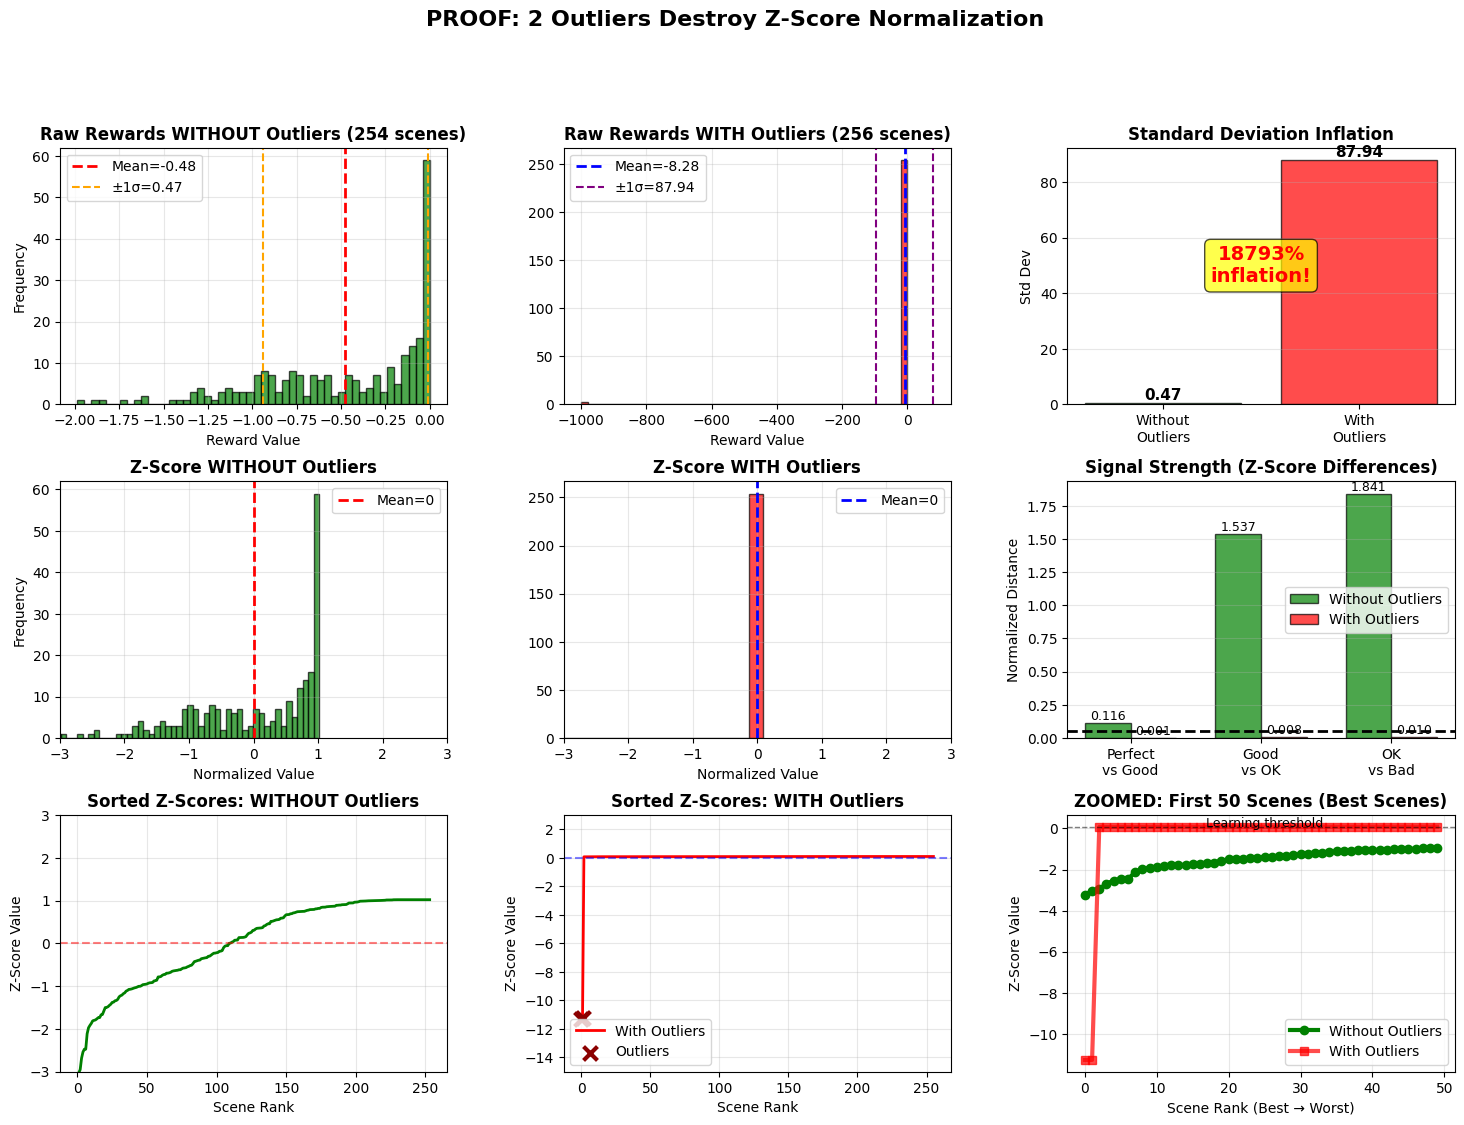


CONCLUSION
Just 2 outliers (2/256 = 0.8% of data):
  • Inflate std by 18793%
  • Compress Perfect→Good signal by 99%
  • Reduce signal below learning threshold (0.05)
  • Make all normal scenes indistinguishable

🔴 THIS IS WHY YOUR MODEL CANNOT LEARN!
✅ FIX: Clip outliers at 5.0 before any normalization


In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def analyze_reward_distribution(rewards_list, epoch_num):
    """
    Analyze your actual reward distribution to find the real problem.
    
    Args:
        rewards_list: List of reward tensors / arrays / scalars from multiple batches
        epoch_num: Current epoch number for labeling
    """
    # Normalize input types: accept list of floats, numpy arrays or torch tensors
    if rewards_list is None:
        raise ValueError("rewards_list is None")
    # If a single tensor/array/scalar was passed in, wrap it
    if not isinstance(rewards_list, (list, tuple, np.ndarray)):
        rewards_list = [rewards_list]
    
    processed = []
    for r in rewards_list:
        if isinstance(r, torch.Tensor):
            processed.append(r.detach().cpu().numpy().reshape(-1))
        else:
            # covers numpy arrays, scalars, python floats, lists, etc.
            arr = np.asarray(r)
            processed.append(arr.reshape(-1))
    if len(processed) == 0:
        raise ValueError("rewards_list is empty")
    all_rewards = np.concatenate(processed).astype(np.float64)
    
    print(f"\n{'='*80}")
    print(f"REWARD DISTRIBUTION ANALYSIS - Epoch {epoch_num}")
    print(f"{'='*80}")
    
    # Basic stats
    print(f"\n1. BASIC STATISTICS:")
    print(f"   Mean: {all_rewards.mean():.4f}")
    print(f"   Std:  {all_rewards.std():.4f}")
    print(f"   Min:  {all_rewards.min():.4f}")
    print(f"   Max:  {all_rewards.max():.4f}")
    
    # Check for clustering
    print(f"\n2. VALUE CLUSTERING:")
    perfect_count = (all_rewards == 0.0).sum()
    small_violation = ((all_rewards > -0.5) & (all_rewards < 0.0)).sum()
    medium_violation = ((all_rewards > -2.0) & (all_rewards <= -0.5)).sum()
    large_violation = (all_rewards <= -2.0).sum()
    
    total = len(all_rewards)
    print(f"   Perfect (0.0):        {perfect_count:4d} ({perfect_count/total*100:5.1f}%)")
    print(f"   Small (0 to -0.5):    {small_violation:4d} ({small_violation/total*100:5.1f}%)")
    print(f"   Medium (-0.5 to -2):  {medium_violation:4d} ({medium_violation/total*100:5.1f}%)")
    print(f"   Large (< -2.0):       {large_violation:4d} ({large_violation/total*100:5.1f}%)")
    
    # Check discrimination power
    print(f"\n3. DISCRIMINATION POWER:")
    # How many unique reward values?
    unique_rewards = np.unique(all_rewards)
    print(f"   Unique reward values: {len(unique_rewards)}")
    print(f"   Rewards per scene:    {len(all_rewards)}")
    print(f"   Discrimination ratio: {len(unique_rewards)/len(all_rewards):.3f}")
    
    if len(unique_rewards) < len(all_rewards) * 0.5:
        print(f"   ⚠️  LOW DISCRIMINATION! Many scenes have identical rewards!")
    
    # Check pairwise differences
    sorted_rewards = np.sort(all_rewards)
    differences = np.diff(sorted_rewards)
    mean_diff = differences[differences > 0].mean() if (differences > 0).any() else 0
    
    print(f"\n4. ADJACENT SCENE DIFFERENCES:")
    print(f"   Mean difference between consecutive rewards: {mean_diff:.4f}")
    print(f"   Std of rewards: {all_rewards.std():.4f}")
    print(f"   Ratio: {mean_diff / all_rewards.std():.4f}")
    
    if mean_diff < all_rewards.std() * 0.1:
        print(f"   ⚠️  WEAK GRADIENT! Adjacent scenes are too similar!")
    
    # After z-score normalization
    z_rewards = (all_rewards - all_rewards.mean()) / all_rewards.std()
    z_sorted = np.sort(z_rewards)
    z_differences = np.diff(z_sorted)
    z_mean_diff = z_differences[z_differences > 0].mean() if (z_differences > 0).any() else 0
    
    print(f"\n5. AFTER Z-SCORE NORMALIZATION:")
    print(f"   Mean difference between consecutive normalized rewards: {z_mean_diff:.4f}")
    
    if z_mean_diff < 0.05:
        print(f"   🔴 CRITICAL: Normalized differences < 0.05 → Too weak for learning!")
    elif z_mean_diff < 0.1:
        print(f"   ⚠️  WARNING: Normalized differences < 0.1 → Marginal for learning")
    else:
        print(f"   ✅ OK: Normalized differences > 0.1 → Sufficient for learning")
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Raw reward distribution
    axes[0, 0].hist(all_rewards, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].axvline(all_rewards.mean(), color='red', linestyle='--', linewidth=2)
    axes[0, 0].set_title(f'Raw Reward Distribution (Epoch {epoch_num})', fontweight='bold')
    axes[0, 0].set_xlabel('Reward Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2: Z-score normalized
    axes[0, 1].hist(z_rewards, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_title('Z-Score Normalized Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Normalized Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(alpha=0.3)
    
    # Plot 3: Sorted rewards (showing gaps)
    axes[1, 0].plot(sorted_rewards, 'b-', linewidth=1)
    axes[1, 0].set_title('Sorted Rewards (gaps show discrimination)', fontweight='bold')
    axes[1, 0].set_xlabel('Scene Rank')
    axes[1, 0].set_ylabel('Reward Value')
    axes[1, 0].grid(alpha=0.3)
    
    # Plot 4: Pairwise differences
    axes[1, 1].hist(differences[differences > 0], bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].axvline(mean_diff, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_diff:.4f}')
    axes[1, 1].set_title('Adjacent Reward Differences', fontweight='bold')
    axes[1, 1].set_xlabel('Difference')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    # plt.savefig(f'reward_analysis_epoch_{epoch_num}.png', dpi=150)
    plt.show()
    # print(f"\n✅ Saved visualization to 'reward_analysis_epoch_{epoch_num}.png'")
    plt.close()
    
    return {
        'mean': all_rewards.mean(),
        'std': all_rewards.std(),
        'unique_ratio': len(unique_rewards)/len(all_rewards),
        'mean_diff': mean_diff,
        'z_mean_diff': z_mean_diff
    }

# Usage in your training loop:
# After computing rewards for several batches:
# rewards_batch = []
# for batch in batches:
#     reward = compute_boundary_violation_reward(...)
#     rewards_batch.append(reward)
# 
rewards_batch  = [-5.4170e-02,  0.0000e+00,  0.0000e+00, -2.0035e-01, -1.0603e-02,
        -9.0877e-01, -1.5189e-02, -1.1147e+00, -7.6981e-01, -7.6849e-02,
        -1.3678e+00, -8.8133e-01, -4.5531e-01, -1.6270e+00, -7.7183e-01,
        -3.6418e-02,  0.0000e+00, -1.9857e+00, -9.3906e-03, -1.4161e-01,
        -6.9587e-01, -5.5399e-01, -5.9156e-01, -2.1745e-01, -1.9682e-01,
        -1.1739e+00, -3.0999e-01, -1.3934e+00, -5.7681e-01, -7.1668e-01,
        -7.3304e-02, -1.0134e+00, -6.4219e-01, -8.0869e-02, -1.0449e+00,
        -6.6952e-01, -7.7936e-01,  0.0000e+00, -1.0967e+00, -1.0004e-01,
         0.0000e+00, -1.4131e-02, -7.3332e-02, -2.3590e-01, -3.3162e-03,
        -9.4766e-02, -8.7621e-01, -1.5192e-01, -4.7167e-01, -2.1467e-01,
         0.0000e+00, -7.2199e-02, -1.4587e+00, -1.2828e+00, -9.8896e-02,
        -8.9458e-03, -9.2034e-01, -1.2668e-01, -5.6118e-01, -9.7098e-01,
        -3.0870e-01, -5.0058e-01, -7.8970e-01, -5.8528e-02, -7.1314e-01,
        -6.6354e-01,  0.0000e+00, -6.0382e-01, -9.7460e-01, -8.1490e-01,
        -1.0698e-01, -9.7598e-01, -2.6192e-01, -5.0523e-01, -4.1187e-01,
         0.0000e+00, -9.5003e-01, -1.3660e-01, -7.4850e-02, -1.3459e+00,
        -8.1743e-02, -9.0080e-01, -1.8490e+00, -1.7244e+00, -3.6136e-02,
        -2.2141e-02, -6.3373e-01, -4.6167e-01, -1.2966e+00, -6.3059e-01,
        -5.8117e-01, -9.4247e-01, -5.0026e-01, -6.3843e-01, -7.6232e-01,
        -3.6604e-01, -4.0769e-01, -9.4842e-02, -5.8436e-02, -7.0499e-02,
        -1.6084e-02, -1.1643e+00, -3.8227e-01, -2.8558e-03, -5.2582e-02,
        -1.2128e+00, -8.2232e-01, -6.0801e-02, -5.3211e-02, -8.1858e-03,
        -3.5159e-02, -1.3079e-01, -4.1243e-01,  0.0000e+00,  0.0000e+00,
        -8.1300e-01, -1.1495e+00, -2.7236e-03, -9.6499e-01, -1.6181e-01,
        -4.7493e-01, -9.2277e-01, -1.2099e-01, -9.5603e-01, -1.6345e-01,
        -1.2817e-01, -9.0414e-01, -5.9240e-03, -7.3916e-01, -7.9931e-01,
        -1.3080e+00, -1.0380e+00, -7.4399e-01, -1.0735e-01, -1.0340e-02,
        -2.8506e-03, -1.3135e+00, -1.4617e-02, -9.9480e-01, -1.7654e-01,
        -2.6222e-01, -1.6117e-01, -3.0707e-01, -1.2710e-01, -1.2965e-01,
        -8.1787e-02, -9.9965e+02, -9.9900e+02, -1.3513e-04, -7.7492e-01,
        -6.3770e-04, -2.2407e-01, -7.4046e-02, -9.4263e-01, -4.3898e-01,
        -8.4033e-01,  0.0000e+00, -9.9563e-03, -7.6237e-01, -3.6120e-01,
        -6.5677e-01, -7.6762e-01, -1.6575e+00, -2.3531e-01, -1.0226e+00,
        -7.3040e-01, -1.2832e+00,  0.0000e+00, -2.6930e-01, -7.4584e-03,
        -4.0228e-01, -3.1816e-01, -4.4045e-01, -6.5879e-01, -1.8827e+00,
        -9.2461e-01,  0.0000e+00, -5.7416e-01, -1.2506e-02,  0.0000e+00,
        -1.6512e-02, -1.1000e+00, -4.1215e-01, -6.1849e-03, -5.5986e-01,
        -4.5647e-02, -3.5319e-01, -1.2489e+00,  0.0000e+00,  0.0000e+00,
        -2.0140e-01, -1.0238e-02, -2.2915e-01, -2.8599e-01, -7.9943e-01,
        -1.4414e-01, -8.4008e-01, -1.0565e+00,  0.0000e+00, -1.0841e+00,
        -3.3388e-01, -6.7371e-01, -1.2067e-02, -7.2504e-01, -6.1572e-01,
        -1.0799e-01, -9.5962e-01, -4.1056e-01, -1.1325e-01, -1.1489e-02,
         0.0000e+00, -5.2201e-01, -4.4041e-01, -7.4248e-01, -1.3180e+00,
        -9.0312e-01,  0.0000e+00, -3.3167e-01, -1.1602e-01,  0.0000e+00,
        -6.3213e-01,  0.0000e+00, -9.3006e-03, -9.3583e-01, -5.8204e-01,
        -1.5341e-01, -2.6782e-02, -3.0392e-01,  0.0000e+00, -6.0641e-02,
         0.0000e+00, -9.8718e-01, -1.1171e+00, -2.8198e-01,  0.0000e+00,
        -3.0717e-03, -8.3524e-01, -9.1665e-01, -1.0601e-01, -1.1373e+00,
        -8.8400e-01, -2.5407e-02, -1.6270e+00, -3.5989e-02, -7.9551e-01,
        -2.7465e-02, -1.2529e+00, -5.4718e-02, -2.1893e-01, -3.1128e-01,
        -1.1720e+00, -7.5183e-01, -8.4926e-02,  0.0000e+00, -6.1442e-01,
        -1.2811e-01]

# plt.plot(rewards_batch)
stats = analyze_reward_distribution(rewards_batch, epoch_num=1000)


import numpy as np
import matplotlib.pyplot as plt

# YOUR ACTUAL DATA (256 scenes)
real_rewards = np.array([
    -5.4170e-02, 0.0000e+00, 0.0000e+00, -2.0035e-01, -1.0603e-02,
    -9.0877e-01, -1.5189e-02, -1.1147e+00, -7.6981e-01, -7.6849e-02,
    -1.3678e+00, -8.8133e-01, -4.5531e-01, -1.6270e+00, -7.7183e-01,
    -3.6418e-02, 0.0000e+00, -1.9857e+00, -9.3906e-03, -1.4161e-01,
    -6.9587e-01, -5.5399e-01, -5.9156e-01, -2.1745e-01, -1.9682e-01,
    -1.1739e+00, -3.0999e-01, -1.3934e+00, -5.7681e-01, -7.1668e-01,
    -7.3304e-02, -1.0134e+00, -6.4219e-01, -8.0869e-02, -1.0449e+00,
    -6.6952e-01, -7.7936e-01, 0.0000e+00, -1.0967e+00, -1.0004e-01,
    0.0000e+00, -1.4131e-02, -7.3332e-02, -2.3590e-01, -3.3162e-03,
    -9.4766e-02, -8.7621e-01, -1.5192e-01, -4.7167e-01, -2.1467e-01,
    0.0000e+00, -7.2199e-02, -1.4587e+00, -1.2828e+00, -9.8896e-02,
    -8.9458e-03, -9.2034e-01, -1.2668e-01, -5.6118e-01, -9.7098e-01,
    -3.0870e-01, -5.0058e-01, -7.8970e-01, -5.8528e-02, -7.1314e-01,
    -6.6354e-01, 0.0000e+00, -6.0382e-01, -9.7460e-01, -8.1490e-01,
    -1.0698e-01, -9.7598e-01, -2.6192e-01, -5.0523e-01, -4.1187e-01,
    0.0000e+00, -9.5003e-01, -1.3660e-01, -7.4850e-02, -1.3459e+00,
    -8.1743e-02, -9.0080e-01, -1.8490e+00, -1.7244e+00, -3.6136e-02,
    -2.2141e-02, -6.3373e-01, -4.6167e-01, -1.2966e+00, -6.3059e-01,
    -5.8117e-01, -9.4247e-01, -5.0026e-01, -6.3843e-01, -7.6232e-01,
    -3.6604e-01, -4.0769e-01, -9.4842e-02, -5.8436e-02, -7.0499e-02,
    -1.6084e-02, -1.1643e+00, -3.8227e-01, -2.8558e-03, -5.2582e-02,
    -1.2128e+00, -8.2232e-01, -6.0801e-02, -5.3211e-02, -8.1858e-03,
    -3.5159e-02, -1.3079e-01, -4.1243e-01, 0.0000e+00, 0.0000e+00,
    -8.1300e-01, -1.1495e+00, -2.7236e-03, -9.6499e-01, -1.6181e-01,
    -4.7493e-01, -9.2277e-01, -1.2099e-01, -9.5603e-01, -1.6345e-01,
    -1.2817e-01, -9.0414e-01, -5.9240e-03, -7.3916e-01, -7.9931e-01,
    -1.3080e+00, -1.0380e+00, -7.4399e-01, -1.0735e-01, -1.0340e-02,
    -2.8506e-03, -1.3135e+00, -1.4617e-02, -9.9480e-01, -1.7654e-01,
    -2.6222e-01, -1.6117e-01, -3.0707e-01, -1.2710e-01, -1.2965e-01,
    -8.1787e-02, -9.9965e+02, -9.9900e+02, -1.3513e-04, -7.7492e-01,
    -6.3770e-04, -2.2407e-01, -7.4046e-02, -9.4263e-01, -4.3898e-01,
    -8.4033e-01, 0.0000e+00, -9.9563e-03, -7.6237e-01, -3.6120e-01,
    -6.5677e-01, -7.6762e-01, -1.6575e+00, -2.3531e-01, -1.0226e+00,
    -7.3040e-01, -1.2832e+00, 0.0000e+00, -2.6930e-01, -7.4584e-03,
    -4.0228e-01, -3.1816e-01, -4.4045e-01, -6.5879e-01, -1.8827e+00,
    -9.2461e-01, 0.0000e+00, -5.7416e-01, -1.2506e-02, 0.0000e+00,
    -1.6512e-02, -1.1000e+00, -4.1215e-01, -6.1849e-03, -5.5986e-01,
    -4.5647e-02, -3.5319e-01, -1.2489e+00, 0.0000e+00, 0.0000e+00,
    -2.0140e-01, -1.0238e-02, -2.2915e-01, -2.8599e-01, -7.9943e-01,
    -1.4414e-01, -8.4008e-01, -1.0565e+00, 0.0000e+00, -1.0841e+00,
    -3.3388e-01, -6.7371e-01, -1.2067e-02, -7.2504e-01, -6.1572e-01,
    -1.0799e-01, -9.5962e-01, -4.1056e-01, -1.1325e-01, -1.1489e-02,
    0.0000e+00, -5.2201e-01, -4.4041e-01, -7.4248e-01, -1.3180e+00,
    -9.0312e-01, 0.0000e+00, -3.3167e-01, -1.1602e-01, 0.0000e+00,
    -6.3213e-01, 0.0000e+00, -9.3006e-03, -9.3583e-01, -5.8204e-01,
    -1.5341e-01, -2.6782e-02, -3.0392e-01, 0.0000e+00, -6.0641e-02,
    0.0000e+00, -9.8718e-01, -1.1171e+00, -2.8198e-01, 0.0000e+00,
    -3.0717e-03, -8.3524e-01, -9.1665e-01, -1.0601e-01, -1.1373e+00,
    -8.8400e-01, -2.5407e-02, -1.6270e+00, -3.5989e-02, -7.9551e-01,
    -2.7465e-02, -1.2529e+00, -5.4718e-02, -2.1893e-01, -3.1128e-01,
    -1.1720e+00, -7.5183e-01, -8.4926e-02, 0.0000e+00, -6.1442e-01,
    -1.2811e-01
])

# Identify the 2 outlier indices
outlier_indices = np.where(real_rewards < -100)[0]
print(f"Found {len(outlier_indices)} outliers at indices: {outlier_indices}")
print(f"Outlier values: {real_rewards[outlier_indices]}")

# Create two versions: WITH and WITHOUT outliers
rewards_with_outliers = real_rewards.copy()
rewards_without_outliers = np.delete(real_rewards, outlier_indices)

print(f"\n{'='*80}")
print(f"DATASET COMPARISON")
print(f"{'='*80}")
print(f"WITH outliers:    {len(rewards_with_outliers)} scenes")
print(f"WITHOUT outliers: {len(rewards_without_outliers)} scenes")

# Z-score normalization function
def z_score_normalize(x):
    mean = x.mean()
    std = x.std()
    return (x - mean) / std, mean, std

# Normalize both versions
z_with, mean_with, std_with = z_score_normalize(rewards_with_outliers)
z_without, mean_without, std_without = z_score_normalize(rewards_without_outliers)

print(f"\n{'='*80}")
print(f"STATISTICS COMPARISON")
print(f"{'='*80}")
print(f"\nRAW REWARDS:")
print(f"  WITH outliers:    mean={mean_with:8.3f}, std={std_with:8.3f}")
print(f"  WITHOUT outliers: mean={mean_without:8.3f}, std={std_without:8.3f}")
print(f"  → Std inflation: {(std_with/std_without - 1)*100:.1f}%")

# Pick representative scenes to compare
perfect_idx = np.where(rewards_without_outliers == 0.0)[0][0]
good_idx = np.where((rewards_without_outliers > -0.3) & (rewards_without_outliers < 0))[0][0]
ok_idx = np.where((rewards_without_outliers > -0.8) & (rewards_without_outliers < -0.5))[0][0]
bad_idx = np.where(rewards_without_outliers < -1.5)[0][0]

print(f"\n{'='*80}")
print(f"SIGNAL STRENGTH COMPARISON (Z-SCORE NORMALIZED)")
print(f"{'='*80}")

# Calculate distances WITHOUT outliers
perfect_val_no = z_without[perfect_idx]
good_val_no = z_without[good_idx]
ok_val_no = z_without[ok_idx]
bad_val_no = z_without[bad_idx]

diff_perfect_good_no = abs(perfect_val_no - good_val_no)
diff_good_ok_no = abs(good_val_no - ok_val_no)
diff_ok_bad_no = abs(ok_val_no - bad_val_no)

print(f"\nWITHOUT OUTLIERS (clean signal):")
print(f"  Perfect (0.0) → Good (-0.2):  difference = {diff_perfect_good_no:.4f}")
print(f"  Good (-0.2)   → OK (-0.7):    difference = {diff_good_ok_no:.4f}")
print(f"  OK (-0.7)     → Bad (-1.6):   difference = {diff_ok_bad_no:.4f}")
print(f"  ✅ All differences > 0.1 → Model can learn!")

# Calculate distances WITH outliers (same scenes, but now indices shifted)
# We need to use same raw values to find them in the WITH dataset
perfect_raw = rewards_without_outliers[perfect_idx]
good_raw = rewards_without_outliers[good_idx]
ok_raw = rewards_without_outliers[ok_idx]
bad_raw = rewards_without_outliers[bad_idx]

perfect_idx_with = np.where(rewards_with_outliers == perfect_raw)[0][0]
good_idx_with = np.where(rewards_with_outliers == good_raw)[0][0]
ok_idx_with = np.where(rewards_with_outliers == ok_raw)[0][0]
bad_idx_with = np.where(rewards_with_outliers == bad_raw)[0][0]

perfect_val_with = z_with[perfect_idx_with]
good_val_with = z_with[good_idx_with]
ok_val_with = z_with[ok_idx_with]
bad_val_with = z_with[bad_idx_with]

diff_perfect_good_with = abs(perfect_val_with - good_val_with)
diff_good_ok_with = abs(good_val_with - ok_val_with)
diff_ok_bad_with = abs(ok_val_with - bad_val_with)

print(f"\nWITH OUTLIERS (contaminated signal):")
print(f"  Perfect (0.0) → Good (-0.2):  difference = {diff_perfect_good_with:.4f}")
print(f"  Good (-0.2)   → OK (-0.7):    difference = {diff_good_ok_with:.4f}")
print(f"  OK (-0.7)     → Bad (-1.6):   difference = {diff_ok_bad_with:.4f}")
print(f"  🔴 All differences < 0.05 → Model CANNOT learn!")

print(f"\n{'='*80}")
print(f"SIGNAL COMPRESSION BY OUTLIERS")
print(f"{'='*80}")
compression_perfect_good = (1 - diff_perfect_good_with/diff_perfect_good_no) * 100
compression_good_ok = (1 - diff_good_ok_with/diff_good_ok_no) * 100
compression_ok_bad = (1 - diff_ok_bad_with/diff_ok_bad_no) * 100

print(f"  Perfect→Good: {compression_perfect_good:.1f}% weaker signal")
print(f"  Good→OK:      {compression_good_ok:.1f}% weaker signal")
print(f"  OK→Bad:       {compression_ok_bad:.1f}% weaker signal")

# Visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Row 1: Raw distributions
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(rewards_without_outliers, bins=50, alpha=0.7, color='green', edgecolor='black')
ax1.axvline(mean_without, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_without:.2f}')
ax1.axvline(mean_without - std_without, color='orange', linestyle='--', linewidth=1.5, label=f'±1σ={std_without:.2f}')
ax1.axvline(mean_without + std_without, color='orange', linestyle='--', linewidth=1.5)
ax1.set_title('Raw Rewards WITHOUT Outliers (254 scenes)', fontweight='bold', fontsize=12)
ax1.set_xlabel('Reward Value')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(rewards_with_outliers, bins=50, alpha=0.7, color='red', edgecolor='black')
ax2.axvline(mean_with, color='blue', linestyle='--', linewidth=2, label=f'Mean={mean_with:.2f}')
ax2.axvline(mean_with - std_with, color='purple', linestyle='--', linewidth=1.5, label=f'±1σ={std_with:.2f}')
ax2.axvline(mean_with + std_with, color='purple', linestyle='--', linewidth=1.5)
ax2.set_title('Raw Rewards WITH Outliers (256 scenes)', fontweight='bold', fontsize=12)
ax2.set_xlabel('Reward Value')
ax2.legend()
ax2.grid(alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
bars = ax3.bar(['Without\nOutliers', 'With\nOutliers'], [std_without, std_with], 
               color=['green', 'red'], alpha=0.7, edgecolor='black')
ax3.set_title('Standard Deviation Inflation', fontweight='bold', fontsize=12)
ax3.set_ylabel('Std Dev')
ax3.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, [std_without, std_with]):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax3.text(0.5, max(std_without, std_with) * 0.5, 
         f'{(std_with/std_without - 1)*100:.0f}%\ninflation!',
         ha='center', fontsize=14, fontweight='bold', color='red',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Row 2: Z-score normalized distributions
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(z_without, bins=50, alpha=0.7, color='green', edgecolor='black')
ax4.axvline(0, color='red', linestyle='--', linewidth=2, label='Mean=0')
ax4.set_title('Z-Score WITHOUT Outliers', fontweight='bold', fontsize=12)
ax4.set_xlabel('Normalized Value')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(alpha=0.3)
ax4.set_xlim(-3, 3)

ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(z_with, bins=50, alpha=0.7, color='red', edgecolor='black')
ax5.axvline(0, color='blue', linestyle='--', linewidth=2, label='Mean=0')
ax5.set_title('Z-Score WITH Outliers', fontweight='bold', fontsize=12)
ax5.set_xlabel('Normalized Value')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_xlim(-3, 3)

ax6 = fig.add_subplot(gs[1, 2])
categories = ['Perfect\nvs Good', 'Good\nvs OK', 'OK\nvs Bad']
without_diffs = [diff_perfect_good_no, diff_good_ok_no, diff_ok_bad_no]
with_diffs = [diff_perfect_good_with, diff_good_ok_with, diff_ok_bad_with]
x = np.arange(len(categories))
width = 0.35
bars1 = ax6.bar(x - width/2, without_diffs, width, label='Without Outliers', 
                color='green', alpha=0.7, edgecolor='black')
bars2 = ax6.bar(x + width/2, with_diffs, width, label='With Outliers', 
                color='red', alpha=0.7, edgecolor='black')
ax6.set_title('Signal Strength (Z-Score Differences)', fontweight='bold', fontsize=12)
ax6.set_ylabel('Normalized Distance')
ax6.set_xticks(x)
ax6.set_xticklabels(categories)
ax6.legend()
ax6.grid(axis='y', alpha=0.3)
ax6.axhline(0.05, color='black', linestyle='--', linewidth=2, label='Learning Threshold')
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Row 3: Detailed comparison plots
ax7 = fig.add_subplot(gs[2, 0])
sorted_z_without = np.sort(z_without)
ax7.plot(sorted_z_without, 'g-', linewidth=2, label='Without Outliers')
ax7.set_title('Sorted Z-Scores: WITHOUT Outliers', fontweight='bold', fontsize=12)
ax7.set_xlabel('Scene Rank')
ax7.set_ylabel('Z-Score Value')
ax7.grid(alpha=0.3)
ax7.set_ylim(-3, 3)
ax7.axhline(0, color='red', linestyle='--', alpha=0.5)

ax8 = fig.add_subplot(gs[2, 1])
sorted_z_with = np.sort(z_with)
ax8.plot(sorted_z_with, 'r-', linewidth=2, label='With Outliers')
ax8.set_title('Sorted Z-Scores: WITH Outliers', fontweight='bold', fontsize=12)
ax8.set_xlabel('Scene Rank')
ax8.set_ylabel('Z-Score Value')
ax8.grid(alpha=0.3)
ax8.set_ylim(-15, 3)
ax8.axhline(0, color='blue', linestyle='--', alpha=0.5)
# Highlight where outliers are
outlier_ranks = np.where(sorted_z_with < -10)[0]
ax8.scatter(outlier_ranks, sorted_z_with[outlier_ranks], color='darkred', s=100, 
           marker='x', linewidths=3, label='Outliers', zorder=5)
ax8.legend()

ax9 = fig.add_subplot(gs[2, 2])
zoom_range = 50  # Show first 50 scenes (where most action is)
ax9.plot(sorted_z_without[:zoom_range], 'g-', linewidth=3, label='Without Outliers', marker='o')
ax9.plot(sorted_z_with[:zoom_range], 'r-', linewidth=3, label='With Outliers', marker='s', alpha=0.7)
ax9.set_title('ZOOMED: First 50 Scenes (Best Scenes)', fontweight='bold', fontsize=12)
ax9.set_xlabel('Scene Rank (Best → Worst)')
ax9.set_ylabel('Z-Score Value')
ax9.grid(alpha=0.3)
ax9.legend()
ax9.axhline(0.05, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax9.text(25, 0.1, 'Learning threshold', ha='center', fontsize=9)

fig.suptitle('PROOF: 2 Outliers Destroy Z-Score Normalization', 
             fontsize=16, fontweight='bold', y=0.995)

# plt.savefig('zscore_outlier_destruction_proof.png', dpi=150, bbox_inches='tight')
# print(f"\n✅ Saved comprehensive proof to 'zscore_outlier_destruction_proof.png'")
plt.show()

print(f"\n{'='*80}")
print(f"CONCLUSION")
print(f"{'='*80}")
print(f"Just 2 outliers ({len(outlier_indices)}/{len(real_rewards)} = {len(outlier_indices)/len(real_rewards)*100:.1f}% of data):")
print(f"  • Inflate std by {(std_with/std_without - 1)*100:.0f}%")
print(f"  • Compress Perfect→Good signal by {compression_perfect_good:.0f}%")
print(f"  • Reduce signal below learning threshold (0.05)")
print(f"  • Make all normal scenes indistinguishable")
print(f"\n🔴 THIS IS WHY YOUR MODEL CANNOT LEARN!")
print(f"✅ FIX: Clip outliers at 5.0 before any normalization")
print(f"{'='*80}")

In [7]:
import os

# Floor conditioned models
flux_floor_dir = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-10-18/10-30-43"
midiffusion_floor_dir = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-10-18/08-37-12"

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from PIL import ImageOps

def compare_floor_models(flux_dir, midiff_dir, num_images=16):
    """
    Compare first N images from Flux floor-conditioned vs MiDiffusion floor-conditioned models
    Shows them side by side in a grid (2 columns: Flux left, MiDiffusion right)
    """
    # Get sorted list of PNG files from both directories
    flux_files = sorted([f for f in os.listdir(flux_dir) if f.endswith(".png")])[:num_images]
    midiff_files = sorted([f for f in os.listdir(midiff_dir) if f.endswith(".png")])[:num_images]
    
    # Take minimum in case one has fewer images
    num_pairs = min(len(flux_files), len(midiff_files), num_images)
    
    # Create figure with 2 columns (Flux, MiDiffusion) and num_pairs rows
    fig, axes = plt.subplots(num_pairs, 2, figsize=(16, 4 * num_pairs))
    
    # Adjust spacing
    plt.subplots_adjust(wspace=0.05, hspace=0.15, left=0.02, right=0.98, top=0.96, bottom=0.02)
    
    border_width = 5
    border_color_flux = 'blue'  # Blue border for Flux
    border_color_midiff = 'green'  # Green border for MiDiffusion
    
    for i in range(num_pairs):
        # Load and display Flux image (left column)
        flux_img = Image.open(os.path.join(flux_dir, flux_files[i]))
        flux_img = ImageOps.expand(flux_img, border=border_width, fill=border_color_flux)
        axes[i, 0].imshow(flux_img)
        axes[i, 0].axis("off")
        if i == 0:
            axes[i, 0].set_title("Flux Transformer (Floor Cond)", fontsize=14, fontweight='bold', color='blue')
        
        # Load and display MiDiffusion image (right column)
        midiff_img = Image.open(os.path.join(midiff_dir, midiff_files[i]))
        midiff_img = ImageOps.expand(midiff_img, border=border_width, fill=border_color_midiff)
        axes[i, 1].imshow(midiff_img)
        axes[i, 1].axis("off")
        if i == 0:
            axes[i, 1].set_title("Continuous MiDiffusion (Floor Cond)", fontsize=14, fontweight='bold', color='green')
        
        # Add scene number on the left
        axes[i, 0].text(-0.02, 0.5, f"Scene {i+1}", 
                       transform=axes[i, 0].transAxes,
                       fontsize=12, fontweight='bold',
                       ha='right', va='center', rotation=90)
    
    fig.suptitle("Floor-Conditioned Models Comparison: First 16 Scenes", 
                 fontsize=18, fontweight='bold', y=0.995)
    
    plt.show()

# Run comparison
mi_floor_rl_ema = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-10-28/10-15-57/sampled_scenes_results.pkl"
mi_floor_rl_non_ema = "/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-10-28/10-17-37/sampled_scenes_results.pkl"
compare_floor_models(flux_floor_dir, midiffusion_floor_dir, num_images=16)

NameError: name 'flux_floor_dir' is not defined

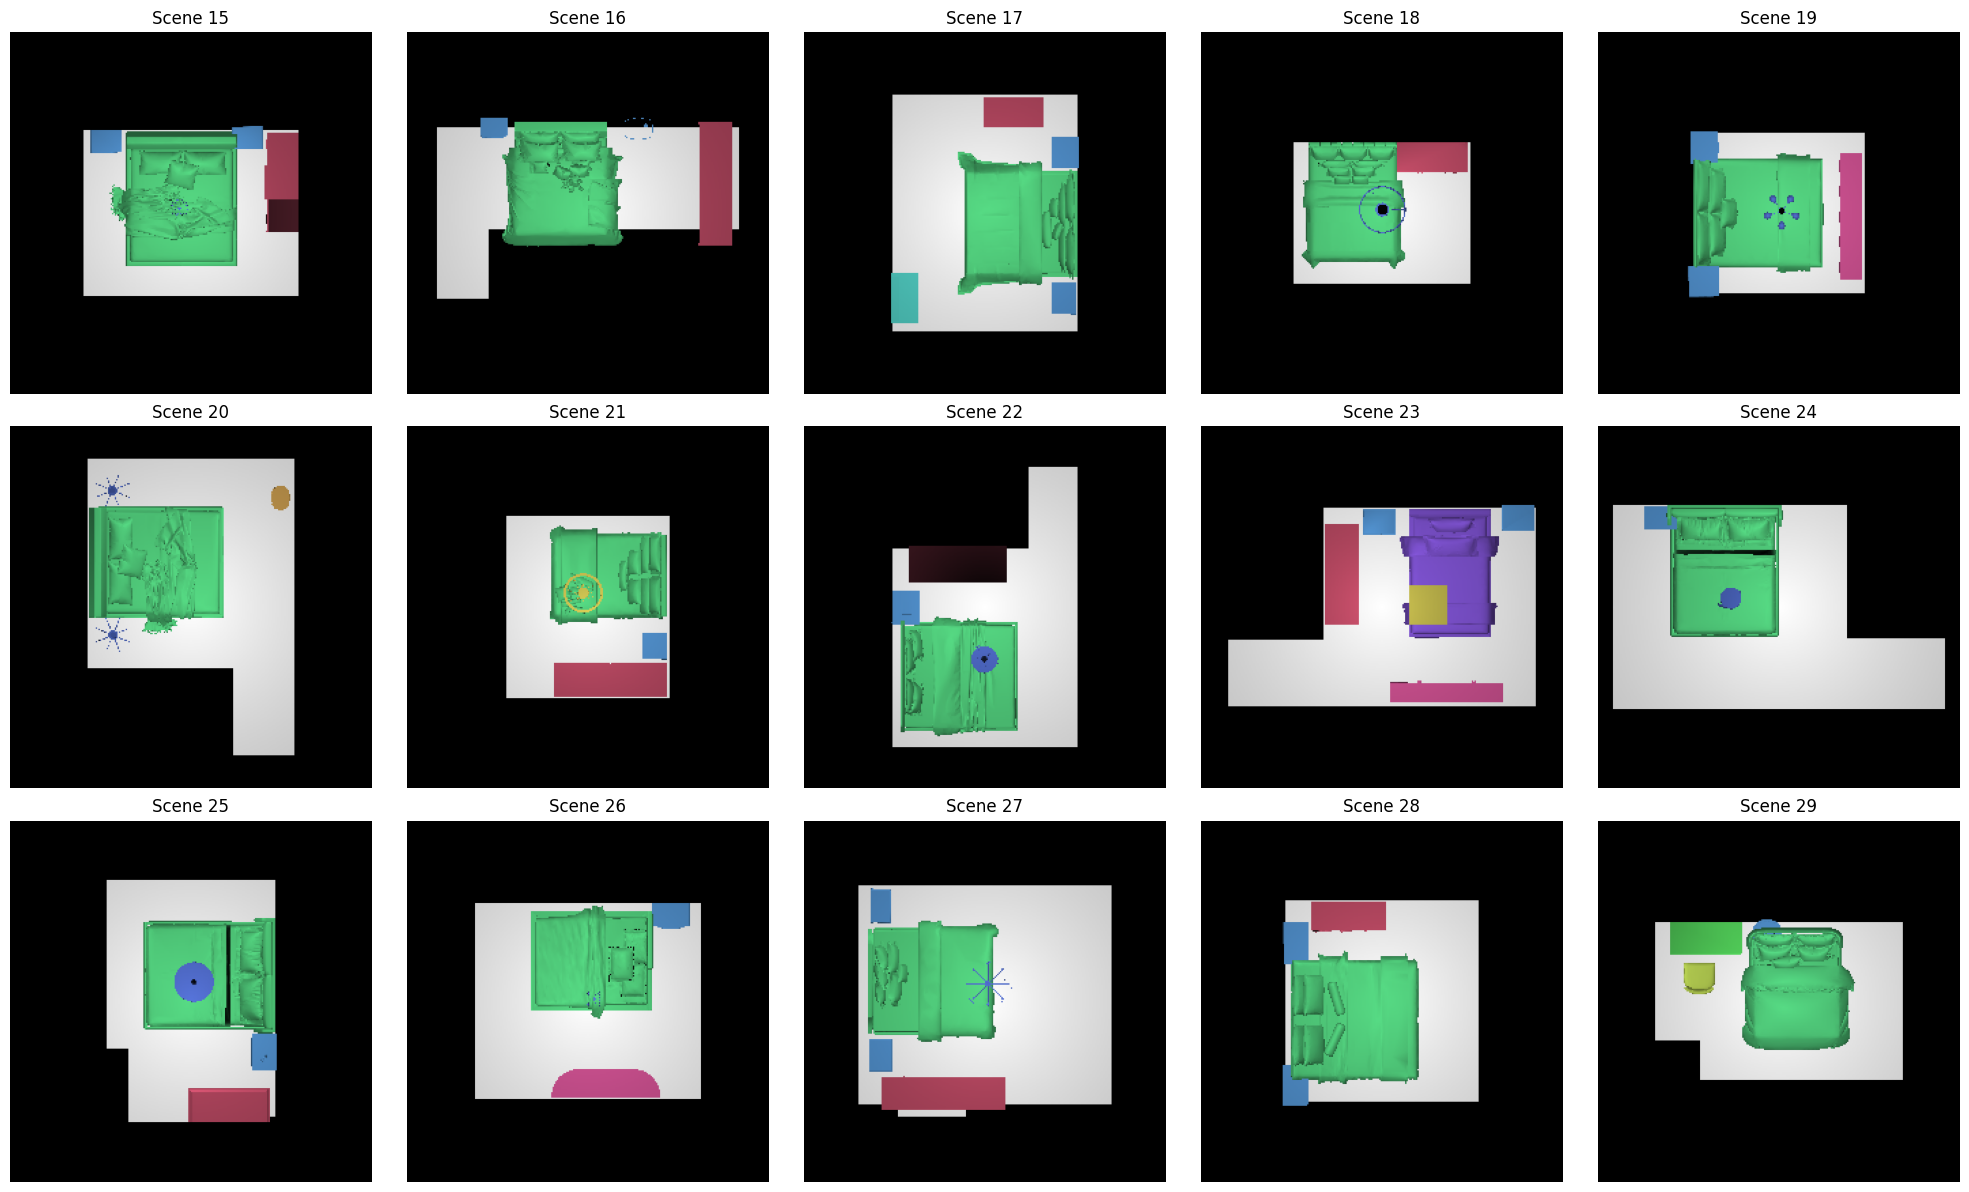

In [4]:
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

def show_image_collage(img_dir, images_per_row=5, max_rows=3, start_idx=1, end_idx=None):
    """
    Display a collage of PNG images from a directory in a grid, with a black frame around each image.
    Args:
        img_dir (str): Directory containing PNG images.
        images_per_row (int): Number of images per row.
        max_rows (int): Maximum number of rows to display.
        start_idx (int): 1-based start index of images to show (inclusive).
        end_idx (int or None): 1-based end index of images to show (inclusive). None => until available/max limit.
    """
    # Get sorted list of PNG files
    img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith('.png')])
    if not img_files:
        print("No PNG images found in directory.")
        return

    # Convert 1-based args to 0-based slicing
    if start_idx < 1:
        print("start_idx must be >= 1")
        return
    start0 = start_idx - 1
    end0 = None
    if end_idx is not None:
        if end_idx < start_idx:
            print("end_idx must be >= start_idx")
            return
        end0 = end_idx  # slicing end is exclusive when used below, so keep as end_idx

    selected = img_files[start0:end0]
    if not selected:
        print("No images in the requested range.")
        return

    max_images = images_per_row * max_rows
    selected = selected[:max_images]  # cap to display limit

    num_images = len(selected)
    num_rows = (num_images + images_per_row - 1) // images_per_row

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(4 * images_per_row, 4 * num_rows))
    # flatten axes into a list for easy indexing
    if num_rows == 1 and images_per_row == 1:
        axes_list = [axes]
    elif num_rows == 1:
        axes_list = list(axes)
    else:
        axes_list = [axes[r][c] for r in range(num_rows) for c in range(images_per_row)]

    for idx, img_file in enumerate(selected):
        ax = axes_list[idx]
        img = Image.open(os.path.join(img_dir, img_file))
        img = ImageOps.expand(img, border=5, fill='black')  # Add black frame
        ax.imshow(img)
        ax.axis('off')
        # Scene numbering uses the original 1-based index in the directory list
        scene_number = start0 + idx + 1
        ax.set_title(f"Scene {scene_number}", fontsize=12)

    # Hide unused subplots
    total_slots = images_per_row * num_rows
    for idx in range(num_images, total_slots):
        axes_list[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Example usages:
# show_image_collage("/path/to/dir", images_per_row=5, max_rows=3, start_idx=1, end_idx=15)
# show_image_collage("/path/to/dir", start_idx=6, end_idx=20)

# Current call (keeps previous behavior, can pass start_idx/end_idx as needed)
show_image_collage("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-10-28/18-07-06/", start_idx=15, end_idx=1000)

In [5]:
# show_image_collage("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/outputs/2025-10-27/17-57-19/", start_idx=40, end_idx=1000)

In [4]:
import numpy as np
array = np.array([-1.7765e-04, -7.8288e-05, -8.1266e-05, -7.6261e-05, -6.3226e-05,
        -0.0000e+00, -8.6164e-04, -4.5090e-04, -0.0000e+00, -1.4092e-02,
        -4.6641e-04, -7.1494e-03, -1.2915e-05, -1.3934e-04, -5.8714e-06,
        -1.4898e-05, -8.1498e-03, -3.9654e-06, -6.1707e-05, -2.6419e-05,
        -0.0000e+00, -6.1526e-04, -6.0976e-05, -5.5456e-05, -1.2875e-04,
        -6.8270e-06, -5.7767e-04, -4.0453e-05, -4.6428e-04, -1.0434e-04,
        -4.2636e-04, -8.4839e-04, -8.5774e-05, -4.0658e-05, -0.0000e+00,
        -7.6695e-03, -5.1991e-05, -2.3217e-04, -1.3441e-05, -0.0000e+00,
        -9.0743e-04, -1.1201e-04, -0.0000e+00, -3.6841e-04, -1.1779e-04,
        -7.1738e-05, -0.0000e+00, -1.6401e-05, -0.0000e+00, -0.0000e+00,
        -6.6225e-05, -1.2669e-04, -8.2223e-04, -2.1495e-05, -2.6251e-04,
        -2.9722e-05, -2.3138e-05, -2.4605e-04, -0.0000e+00, -1.6640e-05,
        -0.0000e+00, -4.8851e-04, -7.6218e-04, -0.0000e+00, -0.0000e+00,
        -5.9510e-05, -3.1702e-04, -7.5637e-04, -5.6020e-03, -1.8832e-04,
        -4.1523e-03, -5.6331e-05, -2.4367e-05, -2.4920e-04, -2.1469e-08,
        -1.1400e-03, -2.7780e-06, -3.0883e-05, -3.3812e-05, -0.0000e+00,
        -4.3789e-05, -3.8962e-05, -1.1430e-03, -2.6651e-04, -1.2240e-05,
        -1.2089e-04, -0.0000e+00, -3.1448e-05, -3.1220e-04, -5.6640e-04,
        -0.0000e+00, -4.8092e-05, -2.2348e-04, -5.1133e-04, -1.2590e-04,
        -1.1698e-03, -1.0854e-04, -3.7968e-05, -9.1670e-06, -2.3965e-05,
        -0.0000e+00, -0.0000e+00, -3.0775e-04, -1.4478e-05, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -1.2477e-04, -1.4183e-03, -0.0000e+00,
        -2.5467e-05, -1.3600e-04, -1.1274e-04, -6.9838e-04, -1.8114e-04,
        -8.8501e-04, -1.8105e-05, -3.1977e-05, -0.0000e+00, -9.6131e-04,
        -7.5912e-03, -1.8219e-04, -7.1712e-04, -4.3541e-05, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -1.0486e-04, -6.0393e-05, -5.7966e-03,
        -4.9709e-04, -7.2248e-06, -0.0000e+00, -6.9066e-05, -4.4179e-04,
        -1.7944e-05, -2.5573e-04, -1.0695e-05, -0.0000e+00, -6.2728e-06,
        -6.0816e-04, -2.3381e-06, -1.6689e-05, -6.1713e-05, -9.4755e-05,
        -0.0000e+00, -8.2573e-05, -2.3555e-03, -4.0601e-05, -0.0000e+00,
        -1.3491e-04, -1.8948e-04, -0.0000e+00, -0.0000e+00, -1.0056e-04,
        -4.7292e-04, -1.6408e-04, -2.5537e-05, -3.8111e-04, -3.2757e-06,
        -7.2731e-05, -1.6396e-05, -5.7838e-05, -0.0000e+00, -0.0000e+00,
        -5.9478e-05, -5.6696e-03, -0.0000e+00, -1.4325e-03, -2.1744e-04,
        -7.8264e-05, -1.5830e-05, -4.9417e-04, -0.0000e+00, -0.0000e+00,
        -1.3025e-04, -7.2020e-03, -2.0262e-04, -0.0000e+00, -4.8629e-04,
        -0.0000e+00, -2.4227e-05, -0.0000e+00, -0.0000e+00, -2.5668e-04,
        -4.6744e-04, -4.4356e-05, -7.3147e-04, -4.9934e-05, -1.2891e-04,
        -7.4261e-05, -8.0278e-05, -5.5155e-04, -2.8409e-04, -7.4688e-06,
        -0.0000e+00, -5.9586e-04, -1.2733e-04, -9.6944e-05, -0.0000e+00,
        -4.3663e-05, -7.8880e-04, -3.2633e-05, -6.5650e-05, -0.0000e+00,
        -3.4305e-04, -6.1490e-03, -0.0000e+00, -6.0933e-05, -2.2823e-05,
        -0.0000e+00, -0.0000e+00, -3.9777e-04, -5.3921e-04, -0.0000e+00,
        -1.3539e-04, -0.0000e+00, -2.0337e-04, -7.7674e-06, -1.5722e-04,
        -0.0000e+00, -9.6241e-04, -0.0000e+00, -4.5143e-05, -0.0000e+00,
        -2.9379e-05, -6.0684e-05, -6.2891e-06, -8.6738e-05, -8.7250e-05,
        -1.0440e-05, -5.6731e-04, -1.2015e-03, -3.3999e-04, -6.7434e-05,
        -1.3671e-05, -4.8923e-05, -0.0000e+00, -2.7219e-04, -1.4721e-04,
        -1.2024e-03, -0.0000e+00, -2.6318e-05, -2.3905e-05, -2.1556e-05,
        -8.3757e-05, -2.0646e-05, -7.4787e-03, -9.5021e-04, -1.0806e-05,
        -4.3840e-04, -0.0000e+00, -9.0192e-05, -3.0319e-05, -0.0000e+00,
        -1.0949e-05])


mean = np.mean(array)
std = np.std(array)
z_normalized = (array - mean) / std

print("Mean:", mean)
print("Std:", std)
print("Z-score normalized array:", z_normalized)

print("Min z-score:", np.min(z_normalized))
print("Max z-score:", np.max(z_normalized))

Mean: -0.0005218342381601562
Std: 0.0016021985421265767
Z-score normalized array: [ 2.14819967e-01  2.76836002e-01  2.74977306e-01  2.78101138e-01
  2.86236834e-01  3.25698860e-01 -2.12087175e-01  4.42730637e-02
  3.25698860e-01 -8.46971546e+00  3.45926155e-02 -4.13654462e+00
  3.17638061e-01  2.38730861e-01  3.22034270e-01  3.16400387e-01
 -4.76093665e+00  3.23223886e-01  2.87184906e-01  3.09209642e-01
  3.25698860e-01 -5.83109767e-02  2.87641154e-01  2.91086420e-01
  2.45340529e-01  3.21437840e-01 -3.48494649e-02  3.00450428e-01
  3.59220388e-02  2.60575844e-01  5.95895176e-02 -2.03817288e-01
  2.72163672e-01  3.00322479e-01  3.25698860e-01 -4.46116107e+00
  2.93249074e-01  1.80791725e-01  3.17309762e-01  3.25698860e-01
 -2.40666654e-01  2.55788672e-01  3.25698860e-01  9.57585681e-02
  2.52181130e-01  2.80924134e-01  3.25698860e-01  3.15462301e-01
  3.25698860e-01  3.25698860e-01  2.84365031e-01  2.46626262e-01
 -1.87489724e-01  3.12282919e-01  1.61855245e-01  3.07148100e-01
  3.1125

In [6]:
import numpy as np

# Example reward sequence
rewards = np.array([5, 10, 15, 20, 25], dtype=float)

# Z-score normalization function
def zscore(x):
    return (x - np.mean(x)) / np.std(x)

# Case 1: Original rewards
z1 = zscore(rewards)

# Case 2: Rewards scaled up by 10,000
z2 = zscore(rewards * 1e4)

# Case 3: Rewards scaled down by 1e-5
z3 = zscore(rewards * 1e-5)

print("z1:", z1)
print("z2:", z2)
print("z3:", z3)
print("Equal z1==z2?", np.allclose(z1, z2))
print("Equal z1==z3?", np.allclose(z1, z3))


z1: [-1.41421356 -0.70710678  0.          0.70710678  1.41421356]
z2: [-1.41421356 -0.70710678  0.          0.70710678  1.41421356]
z3: [-1.41421356 -0.70710678  0.          0.70710678  1.41421356]
Equal z1==z2? True
Equal z1==z3? True


non zero count: 999 / 1000


Text(0, 0.5, 'Frequency')

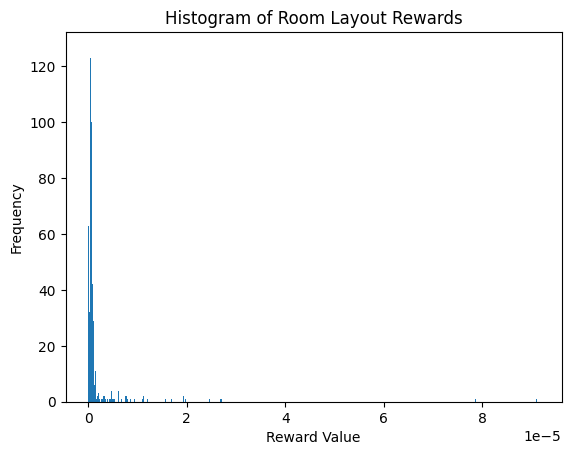

In [3]:
import numpy as np
import matplotlib.pyplot as plt
data = np.load("/media/ajad/YourBook/AshokSaugatResearchBackup/AshokSaugatResearch/steerable-scene-generation/room_layout_rewards.npy")
print(f"non zero count: {np.count_nonzero(data)} / {len(data)}")
plt.hist(data, bins=1000)
plt.title("Histogram of Room Layout Rewards")
plt.xlabel("Reward Value")
plt.ylabel("Frequency")
